In [1]:
import os
import numpy as np
def get_freer_gpu():
    os.system('nvidia-smi -q -d Memory |grep -A4 GPU|grep Free >tmp')
    memory_available = [int(x.split()[2]) for x in open('tmp', 'r').readlines()]
    return np.argmax(memory_available)

gpu = get_freer_gpu()
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu)
print(f'gpu is {gpu}')
import jax
import jax.numpy as jnp
from jax import lax
from jax.ops import index, index_update
import matplotlib.pyplot as plt
import sh
from tqdm import tqdm
import imageio
from PIL import Image


gpu is 1


In [2]:
def get_rays(H, W, focal, c2w):
    i, j = jnp.meshgrid(jnp.linspace(0, W-1, W) + 0.5, jnp.linspace(0, H-1, H) + 0.5) 
    dirs = jnp.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -jnp.ones_like(i)], -1)
    # Rotate ray directions from camera frame to the world frame
    rays_d = jnp.sum(dirs[..., jnp.newaxis, :] * c2w[:3,:3], -1)  # dot product, equals to: [c2w.dot(dir) for dir in dirs]
    # Translate camera frame's origin to the world frame. It is the origin of all rays.
    rays_o = jnp.broadcast_to(c2w[:3,-1], rays_d.shape)
    return rays_o, rays_d

In [3]:
@jax.partial(jax.jit, static_argnums=(2,4,5,6,7,8,9))
def render_rays(grid, rays, resolution, keys, radius=1.3, harmonic_degree=0, jitter=0, uniform=0, interpolation='trilinear', nv=False):
  sh_dim = (harmonic_degree + 1)**2
  voxel_len = radius * 2.0 / resolution
  assert (resolution // 2) * 2 == resolution # Renderer assumes resolution is a multiple of 2
  rays_o, rays_d = rays
  # Compute when the rays enter and leave the grid
  offsets_pos = jax.lax.stop_gradient((radius - rays_o) / rays_d)
  offsets_neg = jax.lax.stop_gradient((-radius - rays_o) / rays_d)
  offsets_in = jax.lax.stop_gradient(jnp.minimum(offsets_pos, offsets_neg))
  offsets_out = jax.lax.stop_gradient(jnp.maximum(offsets_pos, offsets_neg))
  start = jax.lax.stop_gradient(jnp.max(offsets_in, axis=-1, keepdims=True))
  stop = jax.lax.stop_gradient(jnp.min(offsets_out, axis=-1, keepdims=True))
  first_intersection = jax.lax.stop_gradient(rays_o + start * rays_d)
  # Compute locations of ray-voxel intersections along each dimension
  interval = jax.lax.stop_gradient(voxel_len / jnp.abs(rays_d)) # replace voxel_len with voxel_len/2
  offset_bigger = jax.lax.stop_gradient((safe_ceil(first_intersection / voxel_len) * voxel_len - first_intersection) / rays_d)
  offset_smaller = jax.lax.stop_gradient((safe_floor(first_intersection / voxel_len) * voxel_len - first_intersection) / rays_d)
  offset = jax.lax.stop_gradient(jnp.maximum(offset_bigger, offset_smaller))
  # print(first_intersection)

  # Compute the samples along each ray
  matrix = None
  powers = None
  if interpolation == 'tricubic':
    matrix, powers = tricubic_interpolation_matrix()
  if len(rays_o.shape) > 2:
    voxel_sh, voxel_sigma, intersections = get_intersections({"start": start, "stop": stop, "offset": offset, "interval": interval, "ray_o": rays_o, "ray_d": rays_d}, grid, resolution, radius, jitter, uniform, keys, sh_dim, interpolation, matrix, powers)
  else:
    voxel_sh, voxel_sigma, intersections = get_intersections_partial({"start": start, "stop": stop, "offset": offset, "interval": interval, "ray_o": rays_o, "ray_d": rays_d}, grid, resolution, radius, jitter, uniform, keys, sh_dim, interpolation, matrix, powers)
  # Apply spherical harmonics
  # voxel_rgb = sh.eval_sh(harmonic_degree, voxel_sh, rays_d)
  # Call volumetric_rendering
  if harmonic_degree >= 0:
    voxel_rgb = sh.eval_sh(harmonic_degree, voxel_sh, rays_d)
  else:
    voxel_rgb = []
  if nv:
    rgb, disp, acc, weights = nv_rendering(voxel_rgb, voxel_sigma, intersections, rays_d)
  else:
    rgb, disp, acc, weights = volumetric_rendering(voxel_rgb, voxel_sigma, intersections, rays_d)
  pts = rays_o[:, jnp.newaxis, :] + intersections[:, :, jnp.newaxis] * rays_d[:, jnp.newaxis, :]  # [n_rays, n_intersections, 3]
  ids = jnp.clip(jnp.array(jnp.floor(pts / voxel_len + eps) + resolution / 2, dtype=int), a_min=0, a_max=resolution-1)
  return rgb, disp, acc, weights, ids

In [4]:
def get_ct_jerry(root, stage, max_projections):
    all_c2w = []
    all_gt = []

    print('LOAD DATA', root)
    
    projection_matrices = np.genfromtxt(os.path.join('/data/datasets/jerry-cbct/', 'proj_mat.csv'), delimiter=',')  # [719, 12]
    for i in range(len(projection_matrices)-1): 
        index = "{:04d}".format(i)
        im_gt = imageio.imread(os.path.join('/data/datasets/newJerryProj', f'NewJerryProj_{index}.png')).astype(np.float32) / 255.0
        im_gt = 1 - im_gt

        w2c = np.reshape(projection_matrices[i], (3,4))
        w2c[:,-1] = (w2c[:,-1] - [400, 220, 200])
        # invert world -> camera to get camera -> world
        c2w = np.linalg.inv(np.concatenate([w2c, [[0,0,0,1]]], axis=0))

        all_c2w.append(c2w)
        all_gt.append(im_gt) # This one is needed for source projections

    focal = 300

    all_gt = np.asarray(all_gt)
    all_c2w = np.asarray(all_c2w)

    mask = np.zeros(len(all_c2w))
    idx = np.random.choice(len(all_c2w), max_projections, replace = False) # was 500 idx 
    mask[idx] = 1
    mask = mask.astype(bool)

    # train and test can be commented out ot get the full 360 ground truth projections
    if stage == 'train':
        all_gt = all_gt[mask]
        all_c2w = all_c2w[mask]
    elif stage == 'test':
        all_gt = all_gt[~mask]
        all_c2w = all_c2w[~mask]

    return focal, all_c2w, all_gt

In [5]:
root = '/data/datasets'
max_projections = 10

focal, train_c2w, train_gt = get_ct_jerry(root, "train", max_projections)
test_focal, test_c2w, test_gt = get_ct_jerry(root, "test", max_projections)

assert focal == test_focal
H, W = train_gt[0].shape[:2]
n_train_imgs = len(train_c2w)
n_test_imgs = len(test_c2w)

LOAD DATA /data/datasets
LOAD DATA /data/datasets


In [6]:
# Load the reference volume, downsampled to save memory and time for debugging
reference = []
for number in range(200):
    index = "{:04d}".format(number*3)
    img = imageio.imread(f'{root}/jerry-cbct/reference/Reference_RecoFull_8bpp{index}.png')
    img = Image.fromarray((np.squeeze(np.asarray(img))).astype(np.uint8))
    img = img.resize((200, 200))
    reference.append(np.asarray(img) / 255.0)
reference = np.asarray(reference)    
print(f'reference shape is {reference.shape}')

reference shape is (200, 200, 200)


In [7]:
# Utility functions
eps = 1e-5

def safe_floor(vector):
  return jnp.floor(vector + eps)

def safe_ceil(vector):
  return jnp.ceil(vector - eps)

@jax.jit
def grid_lookup(x, y, z, data):
  # indices, data = grid
  # ret = [jnp.where(indices[x,y,z,jnp.newaxis]>=0, d[indices[x,y,z]], jnp.zeros(3)) for d in data[:-1]]
  # ret.append(jnp.where(indices[x,y,z]>=0, data[-1][indices[x,y,z]], 0))
  # return ret
  ret = [jnp.zeros(3) for i in range(len(data[:-1]))]  # Skip expensive lookups during alpha-only optimization
  resolution = int(len(data[-1])**(1./3))
  ret.append(data[-1][x,y,z])
  return ret

@jax.jit
def trilinear_interpolation_weight(xyzs):
  # xyzs should have shape [n_pts, 3] and denote the offset (as a fraction of voxel_len) from the 000 interpolation point
  xs = xyzs[:,0]
  ys = xyzs[:,1]
  zs = xyzs[:,2]
  weight000 = (1-xs) * (1-ys) * (1-zs)  # [n_pts]
  weight001 = (1-xs) * (1-ys) * zs  # [n_pts]
  weight010 = (1-xs) * ys * (1-zs)  # [n_pts]
  weight011 = (1-xs) * ys * zs  # [n_pts]
  weight100 = xs * (1-ys) * (1-zs)  # [n_pts]
  weight101 = xs * (1-ys) * zs  # [n_pts]
  weight110 = xs * ys * (1-zs)  # [n_pts]
  weight111 = xs * ys * zs  # [n_pts]
  weights =  jnp.stack([weight000, weight001, weight010, weight011, weight100, weight101, weight110, weight111], axis=-1) # [n_pts, 8]
  return weights

@jax.partial(jax.jit, static_argnums=(2,3,4,5,8))
def intersection_distances(inputs, data_dict, resolution, radius, jitter, uniform, key, sh_dim, interpolation, matrix, powers):
  start, stop, offset, interval = inputs["start"], inputs["stop"], inputs["offset"], inputs["interval"]
  if uniform == 0:
    # For a single ray, compute all the possible voxel intersections up to the upper bound number, starting when the ray hits the cube
    upper_bound = int(1 + resolution) # per dimension upper bound on the number of voxel intersections
    intersections0 = jnp.linspace(start=start[0] + offset[0], stop=start[0] + offset[0] + interval[0] * upper_bound, num=upper_bound, endpoint=False)
    intersections1 = jnp.linspace(start=start[1] + offset[1], stop=start[1] + offset[1] + interval[1] * upper_bound, num=upper_bound, endpoint=False)
    intersections2 = jnp.linspace(start=start[2] + offset[2], stop=start[2] + offset[2] + interval[2] * upper_bound, num=upper_bound, endpoint=False)
    intersections = jnp.concatenate([intersections0, intersections1, intersections2], axis=None)
    intersections = jnp.sort(intersections) # TODO: replace this with just a merge of the three intersection arrays
  else:
    voxel_len = radius * 2.0 / resolution
    realstart = jnp.min(start)
    count = int(resolution*3 / uniform)
    intersections = jnp.linspace(start=realstart + uniform*voxel_len, stop=realstart + uniform*voxel_len*(count+1), num=count, endpoint=False)
  intersections = jnp.where(intersections <= stop, intersections, stop)
  # Get the values at these intersection points
  ray_o, ray_d = inputs["ray_o"], inputs["ray_d"]
  voxel_sh, voxel_sigma, intersections = values_oneray(intersections, data_dict, ray_o, ray_d, resolution, key, sh_dim, radius, jitter, 1e-5, interpolation, matrix, powers)
  return voxel_sh, voxel_sigma, intersections


get_intersections_partial = jax.vmap(fun=intersection_distances, in_axes=({"start": 0, "stop": 0, "offset": 0, "interval": 0, "ray_o": 0, "ray_d": 0}, None, None, None, None, None, 0, None, None, None, None), out_axes=0)
get_intersections = jax.vmap(fun=get_intersections_partial, in_axes=({"start": 1, "stop": 1, "offset": 1, "interval": 1, "ray_o": 1, "ray_d": 1}, None, None, None, None, None, 1, None, None, None, None), out_axes=1)


@jax.partial(jax.jit, static_argnums=(4,7,8,10))
def values_oneray(intersections, grid, ray_o, ray_d, resolution, key, sh_dim, radius, jitter, eps, interpolation, matrix, powers):
  voxel_len = radius * 2.0 / resolution
  if not jitter:
    pts = ray_o[jnp.newaxis, :] + intersections[:, jnp.newaxis] * ray_d[jnp.newaxis, :]  # [n_intersections, 3]
    pts = pts[:, jnp.newaxis, :]  # [n_intersections, 1, 3]
    offsets = jnp.array([[-1,-1,-1], [-1,-1,1], [-1,1,-1], [-1,1,1], [1,-1,-1], [1,-1,1], [1,1,-1], [1,1,1]]) * voxel_len / 2.0  # [8, 3]
    neighbors = jnp.clip(pts + offsets[jnp.newaxis, :, :], a_min=-radius, a_max=radius)  # [n_intersections, 8, 3]
    neighbor_centers = jnp.clip((jnp.floor(neighbors / voxel_len + eps) + 0.5) * voxel_len, a_min=-(radius - voxel_len/2), a_max=radius - voxel_len/2)  # [n_intersections, 8, 3]
    neighbor_ids = jnp.array(jnp.floor(neighbor_centers / voxel_len + eps) + resolution / 2, dtype=int)  # [n_intersections, 8, 3]
    neighbor_ids = jnp.clip(neighbor_ids, a_min=0, a_max=resolution-1)
    xyzs = (pts[:,0,:] - neighbor_centers[:,0,:]) / voxel_len
    if interpolation == 'tricubic':
      pt_data = tricubic_interpolation(xyzs, neighbor_ids[:,0,:], grid, matrix, powers)
      pt_sigma = pt_data[-1][:-1]
      pt_sh = [d[:-1,:] for d in pt_data[:-1]]
    elif interpolation == 'trilinear':
      weights = trilinear_interpolation_weight(xyzs)  # [n_intersections, 8]
      neighbor_data = grid_lookup(neighbor_ids[...,0], neighbor_ids[...,1], neighbor_ids[...,2], grid)
      neighbor_sh = neighbor_data[:-1]
      neighbor_sigma = neighbor_data[-1]
      pt_sigma = jnp.sum(weights * neighbor_sigma, axis=1)[:-1]
      pt_sh = [jnp.sum(weights[..., jnp.newaxis] * nsh, axis=1)[:-1,:] for nsh in neighbor_sh]
    elif interpolation == 'constant':
      voxel_ids = neighbor_ids[:,0,:]
      voxel_data = jax.vmap(lambda voxel_id: grid_lookup(voxel_id[0], voxel_id[1], voxel_id[2], grid))(voxel_ids)
      pt_sigma = voxel_data[-1][:-1]
      pt_sh = [d[:-1,:] for d in voxel_data[:-1]]
    else:
      print(f'Unrecognized interpolation method {interpolation}.')
      assert False
    return pt_sh, pt_sigma, intersections
  else: # Only does trilinear with jitter
    jitters = jax.random.normal(key=key, shape=(intersections.shape[0],)) * voxel_len * jitter
    jittered_intersections = jnp.clip(intersections + jitters, a_min=intersections[0], a_max=intersections[-1])
    jittered_pts = ray_o[jnp.newaxis, :] + jittered_intersections[:, jnp.newaxis] * ray_d[jnp.newaxis, :]  # [n_intersections, 3]
    jittered_pts = jittered_pts[:, jnp.newaxis, :]  # [n_intersections, 1, 3]
    offsets = jnp.array([[-1,-1,-1], [-1,-1,1], [-1,1,-1], [-1,1,1], [1,-1,-1], [1,-1,1], [1,1,-1], [1,1,1]]) * voxel_len / 2.0  # [8, 3]
    neighbors = jnp.clip(jittered_pts + offsets[jnp.newaxis, :, :], a_min=-radius, a_max=radius)  # [n_intersections, 8, 3]
    neighbor_centers = jnp.clip((jnp.floor(neighbors / voxel_len + eps) + 0.5) * voxel_len, a_min=-(radius - voxel_len/2), a_max=radius - voxel_len/2)  # [n_intersections, 8, 3]
    neighbor_ids = jnp.array(jnp.floor(neighbor_centers / voxel_len + eps) + resolution / 2, dtype=int)  # [n_intersections, 8, 3]
    neighbor_ids = jnp.clip(neighbor_ids, a_min=0, a_max=resolution-1)
    xyzs = (jittered_pts[:,0,:] - neighbor_centers[:,0,:]) / voxel_len
    weights = trilinear_interpolation_weight(xyzs)  # [n_intersections, 8]
    neighbor_data = grid_lookup(neighbor_ids[...,0], neighbor_ids[...,1], neighbor_ids[...,2], grid)
    neighbor_sh = neighbor_data[:-1]
    neighbor_sigma = neighbor_data[-1]
    pt_sigma = jnp.sum(weights * neighbor_sigma, axis=1)[:-1]
    pt_sh = [jnp.sum(weights[..., jnp.newaxis] * nsh, axis=1)[:-1,:] for nsh in neighbor_sh]
    idx = jnp.argsort(jittered_intersections)  # Should be nearly sorted already
    return [sh[idx][:-1] for sh in pt_sh], pt_sigma[idx][:-1], jittered_intersections[idx]

# Based on https://github.com/google-research/google-research/blob/d0a9b1dad5c760a9cfab2a7e5e487be00886803c/jaxnerf/nerf/model_utils.py#L166
def volumetric_rendering(rgb, sigma, z_vals, dirs, white_bkgd=False):
  """Volumetric Rendering Function.
  Args:
    rgb: jnp.ndarray(float32), color, [batch_size, num_samples, 3]
    sigma: jnp.ndarray(float32), density, [batch_size, num_samples].
    z_vals: jnp.ndarray(float32), [batch_size, num_samples].
    dirs: jnp.ndarray(float32), [batch_size, 3].
    white_bkgd: bool.
  Returns:
    comp_rgb: jnp.ndarray(float32), [batch_size, 3].
    disp: jnp.ndarray(float32), [batch_size].
    acc: jnp.ndarray(float32), [batch_size].
    weights: jnp.ndarray(float32), [batch_size, num_samples]
  """
  eps = 1e-10
  dists = z_vals[Ellipsis, 1:] - z_vals[Ellipsis, :-1]
  dists = dists * jnp.linalg.norm(dirs[Ellipsis, None, :], axis=-1)  # Convert ray-relative distance to absolute distance (shouldn't matter if rays_d is normalized)
  # Note that we're quietly turning sigma from [..., 0] to [...].
  alpha = 1.0 - jnp.exp(-jax.nn.relu(sigma) * dists)  # What fraction of light gets stuck in each voxel
  accum_prod = jnp.concatenate([
      jnp.ones_like(alpha[Ellipsis, :1], alpha.dtype),
      jnp.cumprod(1.0 - alpha[Ellipsis, :-1] + eps, axis=-1)
  ],
                               axis=-1)  # How much light is left as we enter each voxel
  weights = alpha * accum_prod  # The absolute amount of light that gets stuck in each voxel
  comp_rgb = (weights[Ellipsis, None] * 1).sum(axis=-2)  # Accumulated color over the samples, ignoring background
  depth = (weights * z_vals[Ellipsis, :-1]).sum(axis=-1) # Weighted average of depths by contribution to final color
  acc = weights.sum(axis=-1)  # Total amount of light absorbed along the ray
  # Equivalent to (but slightly more efficient and stable than):
  #  disp = 1 / max(eps, where(acc > eps, depth / acc, 0))
  inv_eps = 1 / eps
  disp = acc / depth
  disp = jnp.where((disp > 0) & (disp < inv_eps) & (acc > eps), disp, 0) # disparity = inverse depth
  if white_bkgd:
    comp_rgb = comp_rgb + (1. - acc[Ellipsis, None])  # Including the white background in the final color
    
  return comp_rgb, disp, acc, weights

10


100%|██████████| 10/10 [00:05<00:00,  1.72it/s]


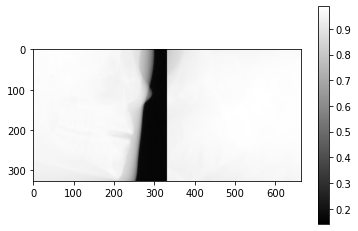

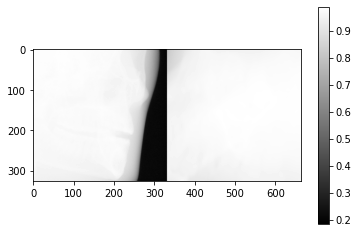

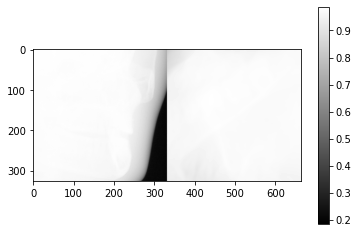

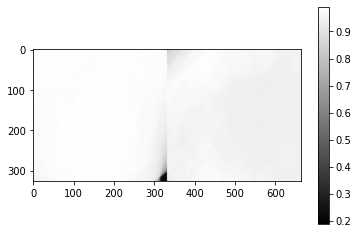

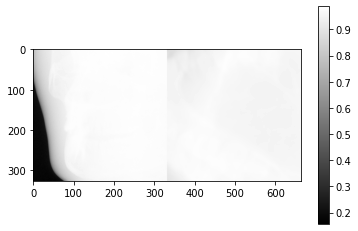

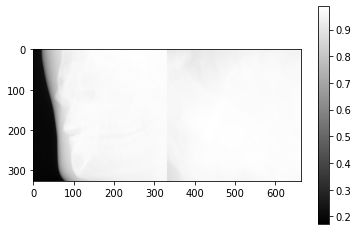

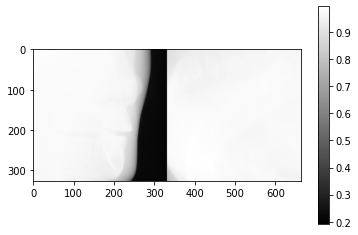

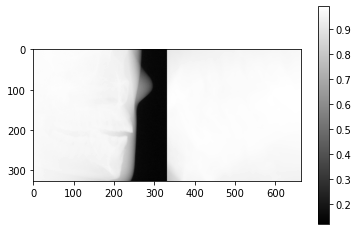

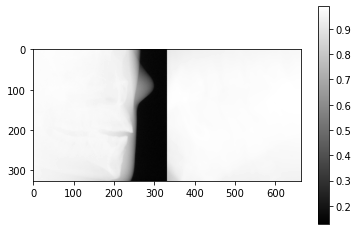

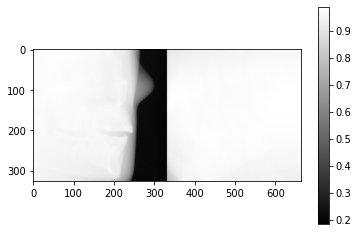

In [8]:
data_dict = ([reference])
resolution = 200
key = None
radius = 5
harmonic_degree = -1
jitter = 0
uniform = 0.5
interpolation = 'trilinear'
nv = False
print(len(train_c2w))
for j, (c2w, gt) in tqdm(enumerate(zip(train_c2w, train_gt)), total=len(train_c2w)):
    (rays_o, rays_d) = get_rays(H, W, focal, c2w)
    # Downsample the rays and the gt image, to save memory
    rays_o = rays_o[::2, ::2, :]
    rays_d = rays_d[::2, ::2, :]
    rayshape = rays_o.shape
    gt = Image.fromarray((np.squeeze(np.asarray(gt)*255)).astype(np.uint8))
    gt = gt.resize(rayshape[0:2])
    gt = np.asarray(gt) / 255.0
    # Render the image
    rays_o = jnp.reshape(rays_o, (-1,3))
    rays_d = jnp.reshape(rays_d, (-1,3))
    gt = jnp.concatenate((gt[...,jnp.newaxis], gt[...,jnp.newaxis], gt[...,jnp.newaxis]), axis=-1)
    rgb, disp, acc, weights, voxel_ids = render_rays(data_dict, (rays_o, rays_d), resolution, key, radius, harmonic_degree, jitter, uniform, interpolation, nv)
    vis = jnp.concatenate((gt[:,:,0], jnp.reshape(rgb, rayshape[0:2]).T), axis = 1)
    plt.figure()
    plt.imshow(vis, cmap='gray')
    plt.colorbar()
    del rays_o, rays_d, gt, rgb, disp, acc, weights, voxel_ids, vis
    # imageio.imwrite(f"/data/fabrizio/multi-energy-ct/here/{j:04}_0001.png", (gt*255).astype(np.uint8))
